# Weakly supervised semantic segmentation

## Multi stage training
= use several individual models to form a training pipeline

CAM $\implies$ offline pixel-level pseudo-labeling $\implies$ train segmentation model

# Approach
Past methods: Use CLIP to improve CAM for better pseudo-labeling\
**Ours**: CLIP-based single-stave pipeline for WSSS with CLIP used to extract strong semantic features for segmentation prediction

# Methods

### Setting Colab and Train

In [ ]:
%%capture
#@title Download datasets and WeCLIP repo

try:
    import google.colab
    IN_COLAB = True
    print("Working in Colab")
except ImportError:
    IN_COLAB = False
    print("Working in Local")

if IN_COLAB:

    from google.colab import userdata
    import os

    # Download FrozenCLIP repo
    !git clone https://github.com/zbf1991/WeCLIP.git

    # Download dataset
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCdevkit_18-May-2011.tar
    !tar -xf VOCdevkit_18-May-2011.tar
    !rm VOCdevkit_18-May-2011.tar
    !cd VOCdevkit/
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
    !tar -xf VOCtrainval_11-May-2012.tar
    !rm VOCtrainval_11-May-2012.tar
    !cd ../

    %cd /content/VOCdevkit/VOC2012/
    !wget https://www.dropbox.com/scl/fi/xccys1fus0utdioi7nj4d/SegmentationClassAug.zip?rlkey=0wl8iz6sc40b3qf6nidun4rez&e=1&dl=0
    !unzip SegmentationClassAug.zip?rlkey=0wl8iz6sc40b3qf6nidun4rez&dl=0

    # Download pretrained ViT-B (non necessario, lo scarica lo script)
    !mkdir WeCLIP/pretrained
    !wget https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt
    !mv ViT-B-16.pt WeCLIP/pretrained/ViT-B-16.pt

Output streaming troncato alle ultime 5000 righe.
  inflating: __MACOSX/SegmentationClassAug/._2010_003928.png  
  inflating: SegmentationClassAug/2010_003929.png  
  inflating: __MACOSX/SegmentationClassAug/._2010_003929.png  
  inflating: SegmentationClassAug/2010_003931.png  
  inflating: __MACOSX/SegmentationClassAug/._2010_003931.png  
  inflating: SegmentationClassAug/2010_003933.png  
  inflating: __MACOSX/SegmentationClassAug/._2010_003933.png  
  inflating: SegmentationClassAug/2010_003936.png  
  inflating: __MACOSX/SegmentationClassAug/._2010_003936.png  
  inflating: SegmentationClassAug/2010_003937.png  
  inflating: __MACOSX/SegmentationClassAug/._2010_003937.png  
  inflating: SegmentationClassAug/2010_003938.png  
  inflating: __MACOSX/SegmentationClassAug/._2010_003938.png  
  inflating: SegmentationClassAug/2010_003939.png  
  inflating: __MACOSX/SegmentationClassAug/._2010_003939.png  
  inflating: SegmentationClassAug/2010_003942.png  
  inflating: __MACOSX/Segmenta

In [22]:
#@title Modify config file
def modify_config(config_file, dataset_path, name_list_path, pretrain_path):
    with open(config_file, 'r') as f:
        config = f.read()



    # Replace paths
    config = config.replace("your/path/VOCdevkit/VOC2012", dataset_path)
    config = config.replace("your/path/WeCLIP/datasets/voc", name_list_path)
    config = config.replace("your/path/WeCLIP/pretrained/ViT-B-16.pt", pretrain_path)

    with open(config_file, 'w') as f:
        f.write(config)

%cd /content/

# Modify VOC config
voc_config = {
    'dataset_path': 'content/VOCdevkit/VOC2012',
    'name_list_path': 'content/WeCLIP/datasets/voc',
    'pretrain_path': 'content/WeCLIP/pretrained/ViT-B-16.pt'
}
modify_config('WeCLIP/configs/voc_attn_reg.yaml', **voc_config)

/content


In [1]:
#@title Environment packages

!pip install "pip<24.1"
!git clone https://github.com/zbf1991/WeCLIP.git

# pydensecrf
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

# mmcv
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121
!pip install openmim
!mim install mmengine
!mim install mmcv==2.1.0

# ftfy and other dependencies
!pip install ftfy regex tqdm
!pip install ftfy==6.1.1  # Specific version if needed

# 2. Install omegaconf (from requirements.txt)
# !pip install omegaconf==2.0.6

!python -c "import ftfy; import clip; print('Imports successful')"

!cat WeCLIP/requirements.txt | grep -v pydensecrf | grep -v mmcv | pip install -r /dev/stdin

!pip install pillow --upgrade

fatal: destination path 'WeCLIP' already exists and is not an empty directory.
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ukj6hkst
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ukj6hkst
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: ftfy
    Found existing installation: ftfy 6.3.

In [ ]:
# Uncomment for Training
# %cd /content/WeCLIP
# !python scripts/dist_clip_voc.py --config configs/voc_attn_reg.yaml

## Overview

Fig.2 shows four main modules:
- a **frozen CLIP backbone** (image encoder and text encoder) to *encode the image and text*,
- a **classification process** to produce *initial CAM*,
- a **decoder** to generate *segmentation predictions*,
- a **RFM** to *refine initial CAM* to provide pseudo labels for training.

In [2]:
#@title Setup: aux functions

import logging
import random
import numpy as np

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def setup_logger(filename='test.log'):
    ## setup logger
    logFormatter = logging.Formatter('%(asctime)s - %(filename)s - %(levelname)s: %(message)s')
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    fHandler = logging.FileHandler(filename, mode='w')
    fHandler.setFormatter(logFormatter)
    logger.addHandler(fHandler)

    cHandler = logging.StreamHandler()
    cHandler.setFormatter(logFormatter)
    logger.addHandler(cHandler)


In [3]:
#@title Configuration

%cd /content/

import argparse
import datetime
import os

import torch
from omegaconf import OmegaConf     # YAML based hierarchical configuration system

args = {
    "config": "WeCLIP/configs/voc_attn_reg.yaml",
    "seg_detach": False,
    "work_dir": None,
    "radius": 8,
    "crop_size": 320
}

cfg = OmegaConf.load(args['config'])
cfg.dataset.crop_size = args['crop_size']

timestamp = "{0:%Y-%m-%d-%H-%M}".format(datetime.datetime.now())

cfg.work_dir.ckpt_dir = os.path.join(cfg.work_dir.dir, cfg.work_dir.ckpt_dir, timestamp)
cfg.work_dir.pred_dir = os.path.join(cfg.work_dir.dir, cfg.work_dir.pred_dir)
cfg.work_dir.tb_logger_dir = os.path.join(cfg.work_dir.dir, cfg.work_dir.tb_logger_dir, timestamp)

os.makedirs(cfg.work_dir.ckpt_dir, exist_ok=True)
os.makedirs(cfg.work_dir.pred_dir, exist_ok=True)
os.makedirs(cfg.work_dir.tb_logger_dir, exist_ok=True)

setup_logger(filename=os.path.join(cfg.work_dir.dir, timestamp+'.log'))
logging.info('\nargs: %s' % args)
logging.info('\nconfigs: %s' % cfg)

setup_seed(1)
# train(cfg=cfg)

INFO:root:
args: {'config': 'WeCLIP/configs/voc_attn_reg.yaml', 'seg_detach': False, 'work_dir': None, 'radius': 8, 'crop_size': 320}
2024-11-02 17:09:47,010 - <ipython-input-3-7e593daf67f1> - INFO: 
args: {'config': 'WeCLIP/configs/voc_attn_reg.yaml', 'seg_detach': False, 'work_dir': None, 'radius': 8, 'crop_size': 320}
INFO:root:
configs: {'dataset': {'root_dir': '/content/VOCdevkit/VOC2012', 'name_list_dir': '/content/WeCLIP/datasets/voc', 'num_classes': 21, 'crop_size': 320, 'resize_range': [512, 2048], 'rescale_range': [0.5, 2.0], 'ignore_index': 255}, 'work_dir': {'dir': 'work_dir_voc', 'ckpt_dir': 'work_dir_voc/checkpoints/2024-11-02-17-09', 'pred_dir': 'work_dir_voc/predictions', 'segs_dir': 'segs', 'tb_logger_dir': 'work_dir_voc/tb_logger/2024-11-02-17-09'}, 'train': {'split': 'train_aug', 'samples_per_gpu': 4, 'max_iters': 30000, 'cam_iters': 2000, 'eval_iters': 2000, 'log_iters': 200}, 'val': {'split': 'train'}, 'optimizer': {'type': 'AdamW', 'learning_rate': 0.0002, 'betas'

/content


Let's decompose the function `train(cfg)`

The Training pipeline is divided into the following steps:

In [122]:
#@title class Datasets

%cd /content/WeCLIP

import os
from datasets import voc
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

num_workers = 10

time0 = datetime.datetime.now()
time0 = time0.replace(microsecond=0)

root_dir = "/content/VOCdevkit/VOC2012"
name_list_dir = "/content/WeCLIP/datasets/voc/"

train_dataset = voc.VOC12ClsDataset(
        root_dir=cfg.dataset.root_dir,
        name_list_dir=cfg.dataset.name_list_dir,
        split=cfg.train.split,
        stage='train',
        aug=True,
        resize_range=cfg.dataset.resize_range,
        rescale_range=cfg.dataset.rescale_range,
        crop_size=cfg.dataset.crop_size,
        img_fliplr=True,
        ignore_index=cfg.dataset.ignore_index,
        num_classes=cfg.dataset.num_classes,
    )

val_dataset = voc.VOC12SegDataset(
    root_dir=cfg.dataset.root_dir,
    name_list_dir=cfg.dataset.name_list_dir,
    split=cfg.val.split,
    stage='train',
    aug=False,
    ignore_index=cfg.dataset.ignore_index,
    num_classes=cfg.dataset.num_classes,
)

train_loader = DataLoader(train_dataset,
                            batch_size=cfg.train.samples_per_gpu,
                            shuffle=True,
                            num_workers=num_workers,
                            pin_memory=False,
                            drop_last=True,
                            prefetch_factor=4)

val_loader = DataLoader(val_dataset,
                            batch_size=1,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=False,
                            drop_last=False)

def visualize_dataset_comparison(index):

    elem = train_dataset[index]

    train_elem = {
        'name_image': elem[0],
        'image': elem[1],
        'label': elem[2]
    }

    elem = val_dataset[index]

    val_elem = {
        'name_image': elem[0],
        'image': elem[1],
        'seg'  : elem[2],
        'label': elem[3]
    }

    label = new_class_names[np.argmax(val_elem['label'])]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Comparison: {train_elem['name_image']} vs {val_elem['name_image']}, label: {label} ")

    # Train data visualization
    # Normalize image data to [0,1] range
    train_img = train_elem['image'].transpose(1,2,0)
    train_img = (train_img - train_img.min()) / (train_img.max() - train_img.min())
    axes[0].imshow(train_img)
    axes[0].set_title('Train Image')

    # Val data visualization
    val_img = val_elem['image'].transpose(1,2,0)
    val_img = (val_img - val_img.min()) / (val_img.max() - val_img.min())
    axes[1].imshow(val_img)
    axes[1].set_title('Val Image')

    # Segmentation mask
    axes[2].imshow(val_elem['seg'], cmap='tab20')
    axes[2].set_title('Val Segmentation')
    plt.tight_layout()
    plt.show()

new_class_names = ['aeroplane', 'bicycle', 'bird avian', 'boat', 'bottle',
                   'bus', 'car', 'cat', 'chair seat', 'cow',
                   'diningtable', 'dog', 'horse', 'motorbike', 'person with clothes,people,human',
                   'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor screen',
                   ]


/content/WeCLIP


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


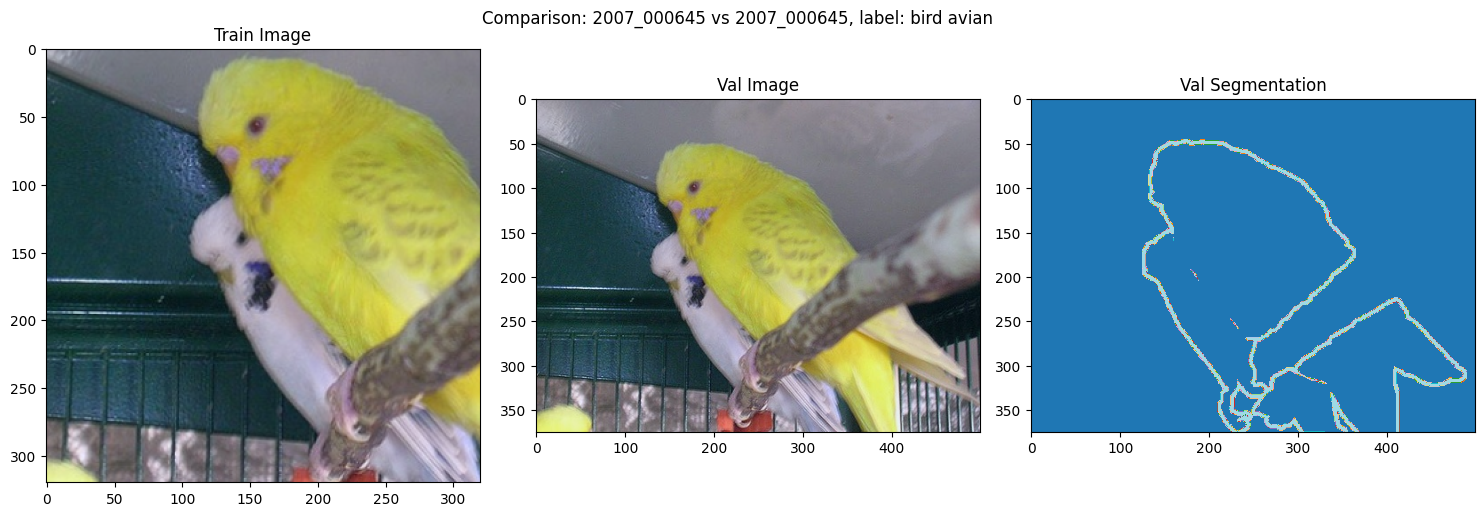

In [125]:
index = 20

visualize_dataset_comparison(index)

In [130]:
#@title CLIP instantiation

from WeCLIP_model.model_attn_aff_voc import WeCLIP
from utils.optimizer import PolyWarmupAdamW
from utils.AverageMeter import AverageMeter

clip_model = 'ViT-B/16'

if torch.cuda.is_available():

    WeCLIP_model = WeCLIP(
        num_classes=cfg.dataset.num_classes,
        clip_model=cfg.clip_init.clip_pretrain_path,                              #cfg.clip_init.clip_pretrain_path,
        embedding_dim=cfg.clip_init.embedding_dim,
        in_channels=cfg.clip_init.in_channels,
        dataset_root_path=cfg.dataset.root_dir,
        device='cuda'
    )

    param_groups = WeCLIP_model.get_param_groups()
    WeCLIP_model.cuda()

    optimizer = PolyWarmupAdamW(
        params=[
            {
                "params": param_groups[0],
                "lr": cfg.optimizer.learning_rate,
                "weight_decay": cfg.optimizer.weight_decay,
            },
            {
                "params": param_groups[1],
                "lr": 0.0,
                "weight_decay": 0.0,
            },
            {
                "params": param_groups[2],
                "lr": cfg.optimizer.learning_rate*10,
                "weight_decay": cfg.optimizer.weight_decay,
            },
            {
                "params": param_groups[3],
                "lr": cfg.optimizer.learning_rate*10,
                "weight_decay": cfg.optimizer.weight_decay,
            },
        ],
        lr = cfg.optimizer.learning_rate,
        weight_decay = cfg.optimizer.weight_decay,
        betas = cfg.optimizer.betas,
        warmup_iter = cfg.scheduler.warmup_iter,
        max_iter = cfg.train.max_iters,
        warmup_ratio = cfg.scheduler.warmup_ratio,
        power = cfg.scheduler.power
    )

else:
    print("No GPU available, WeCLIP not instantiated")

mask_size = int(cfg.dataset.crop_size // 16)

def get_mask_by_radius(h=20, w=20, radius=8):
    hw = h * w
    mask  = np.zeros((hw, hw))
    for i in range(hw):
        _h = i // w
        _w = i % w

        _h0 = max(0, _h - radius)
        _h1 = min(h, _h + radius+1)
        _w0 = max(0, _w - radius)
        _w1 = min(w, _w + radius+1)
        for i1 in range(_h0, _h1):
            for i2 in range(_w0, _w1):
                _i2 = i1 * w + i2
                mask[i, _i2] = 1
                mask[_i2, i] = 1

    return mask

attn_mask = get_mask_by_radius(h=mask_size, w=mask_size, radius=args['radius'])

avg_meter = AverageMeter()

No GPU available, WeCLIP not instantiated


1. First of all, the **image is input** to the CLIP image encoder for image features.\
`segs, cam, attn_pred = WeCLIP_model(inputs.cuda(), img_name)`
    - Besides, the *foreground and background class labels are used to build text prompts* and then input to the CLIP text encoder to *generate the corresponding text features*.
    - Note here both image and text encoders are **frozen** during training.

In [133]:
train_loader_iter = iter(train_loader)

img_name, inputs, cls_labels, img_box = next(train_loader_iter)

if torch.cuda.is_available():
    segs, cam, attn_pred = WeCLIP_model(inputs.cuda(), img_name)

This is the class of WeCLIP:

In [153]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.transforms import Compose, Normalize

from clip.clip_text import new_class_names, BACKGROUND_CATEGORY
from WeCLIP_model.segformer_head import SegFormerHead
import clip
from pytorch_grad_cam import GradCAM
from clip.clip_tool import generate_cam_label, generate_clip_fts, perform_single_voc_cam
from WeCLIP_model.Decoder.TransDecoder import DecoderTransformer
from WeCLIP_model.PAR import PAR


class WeCLIP(nn.Module):
    def __init__(self, num_classes=None, clip_model=None, embedding_dim=256, in_channels=512, dataset_root_path=None, device='cuda'):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        self.encoder, _ = clip.load(clip_model, device=device)

        for name, param in self.encoder.named_parameters():
            if "11" not in name:
                param.requires_grad=False

        for name, param in self.encoder.named_parameters():
            print(name, param.requires_grad)

        self.in_channels = in_channels

        self.decoder_fts_fuse = SegFormerHead(in_channels=self.in_channels,embedding_dim=self.embedding_dim,
                                              num_classes=self.num_classes, index=11)
        self.decoder = DecoderTransformer(width=self.embedding_dim, layers=3, heads=8, output_dim=self.num_classes)

        self.bg_text_features = zeroshot_classifier(BACKGROUND_CATEGORY, ['a clean origami {}.'], self.encoder)
        self.fg_text_features = zeroshot_classifier(new_class_names, ['a clean origami {}.'], self.encoder)

        self.target_layers = [self.encoder.visual.transformer.resblocks[-1].ln_1]
        self.grad_cam = GradCAM(model=self.encoder, target_layers=self.target_layers, reshape_transform=reshape_transform)
        self.root_path = os.path.join(dataset_root_path, 'SegmentationClassAug')
        self.cam_bg_thres = 1
        self.encoder.eval()
        self.par = PAR(num_iter=20, dilations=[1,2,4,8,12,24]).cuda()
        self.iter_num = 0
        self.require_all_fts = True

    def get_param_groups(self):

        param_groups = [[], [], [], []]  # backbone; backbone_norm; cls_head; seg_head;

        for param in list(self.decoder.parameters()):
            param_groups[3].append(param)
        for param in list(self.decoder_fts_fuse.parameters()):
            param_groups[3].append(param)

        return param_groups


    def forward(self, img, img_names='2007_000032', mode='train'):

        # Initial setup
        cam_list = []
        b, c, h, w = img.shape
        self.encoder.eval()             # freeze CLIP model
        self.iter_num += 1

        # CLIP Feature Extraction
        fts_all, attn_weight_list = generate_clip_fts(img, self.encoder, require_all_fts=True)

        # Stacks features and attention weights
        fts_all_stack = torch.stack(fts_all, dim=0) # (11, hw, b, c)
        attn_weight_stack = torch.stack(attn_weight_list, dim=0).permute(1, 0, 2, 3)

        #
        if self.require_all_fts==True:
            cam_fts_all = fts_all_stack[-1].unsqueeze(0).permute(2, 1, 0, 3) #(1, hw, 1, c)
        else:
            cam_fts_all = fts_all_stack.permute(2, 1, 0, 3)

        # Token Processing
        all_img_tokens = fts_all_stack[:, 1:, ...]
        img_tokens_channel = all_img_tokens.size(-1)
        all_img_tokens = all_img_tokens.permute(0, 2, 3, 1)
        all_img_tokens = all_img_tokens.reshape(-1, b, img_tokens_channel, h//16, w //16) #(11, b, c, h, w)

        # Segmentation Generation
        fts = self.decoder_fts_fuse(all_img_tokens)
        attn_fts = fts.clone()
        _, _, fts_h, fts_w = fts.shape

        seg, seg_attn_weight_list = self.decoder(fts)

        f_b, f_c, f_h, f_w = attn_fts.shape
        attn_fts_flatten = attn_fts.reshape(f_b, f_c, f_h*f_w)
        attn_pred = attn_fts_flatten.transpose(2, 1).bmm(attn_fts_flatten)
        attn_pred = torch.sigmoid(attn_pred)

        # CAM Generation
        for i, img_name in enumerate(img_names):
            img_path = os.path.join(self.root_path, str(img_name)+'.png')
            img_i = img[i]
            cam_fts = cam_fts_all[i]
            cam_attn = attn_weight_stack[i]
            seg_attn = attn_pred.unsqueeze(0)[:, i, :, :]

            if self.iter_num > 15000 or mode=='val': #15000
                require_seg_trans = True
            else:
                require_seg_trans = False

            cam_refined_list, keys, w, h = perform_single_voc_cam(img_path, img_i, cam_fts, cam_attn, seg_attn,
                                                                   self.bg_text_features, self.fg_text_features,
                                                                   self.grad_cam,
                                                                   mode=mode,
                                                                   require_seg_trans=require_seg_trans)


            cam_dict = generate_cam_label(cam_refined_list, keys, w, h)

            cams = cam_dict['refined_cam'].cuda()

            bg_score = torch.pow(1 - torch.max(cams, dim=0, keepdims=True)[0], self.cam_bg_thres).cuda()
            cams = torch.cat([bg_score, cams], dim=0).cuda()

            valid_key = np.pad(cam_dict['keys'] + 1, (1, 0), mode='constant')
            valid_key = torch.from_numpy(valid_key).cuda()

            with torch.no_grad():
                cam_labels = _refine_cams(self.par, img[i], cams, valid_key)

            cam_list.append(cam_labels)

        all_cam_labels = torch.stack(cam_list, dim=0)

        return seg, all_cam_labels, attn_pred

Let's decompose the code.

In [134]:
# from clip.clip_text import new_class_names, BACKGROUND_CATEGORY

new_class_names = ['aeroplane', 'bicycle', 'bird avian', 'boat', 'bottle',
                   'bus', 'car', 'cat', 'chair seat', 'cow',
                   'diningtable', 'dog', 'horse', 'motorbike', 'person with clothes,people,human',
                   'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor screen',
                   ]

BACKGROUND_CATEGORY = ['ground','land','grass','tree','building','wall','sky','lake','water','river','sea','railway','railroad','keyboard','helmet',
                        'cloud','house','mountain','ocean','road','rock','street','valley','bridge','sign',
                        ]

In [136]:
#@title SegFormerHead

# from .segformer_head import SegFormerHead

import torch.nn.functional as F
import torch.nn as nn

class MLP(nn.Module):
    """
    Linear Embedding

    2 Linear Layers with ReLU activation in between
    """
    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.proj_2 = nn.Linear(embed_dim, embed_dim)
        # self.proj_3 = nn.Linear(embed_dim*2, embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        x = F.relu(x)
        x = self.proj_2(x)
        return x


class SegFormerHead(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers

    Flow Diagram:
        Input [stages, B, C, H, W]
        ↓
        For each stage:
        → MLP projection
        → Reshape to spatial
        ↓
        Concatenate features
        ↓
        1x1 Conv fusion
        ↓
        Dropout
        ↓
        Output [B, embedding_dim, H, W]
    """
    def __init__(self, in_channels=128, embedding_dim=256, num_classes=20, index=11, **kwargs):
        super(SegFormerHead, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.indexes = index #6 #11

        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = self.in_channels

        # one MLP module for every Transformer feature, num given by index
        linear_layers = [MLP(input_dim=c1_in_channels, embed_dim=embedding_dim) for i in range(self.indexes)]
        self.linears_modulelist = nn.ModuleList(linear_layers)      # list of modules, handy for iterate through modules

        self.linear_fuse = nn.Conv2d(embedding_dim*self.indexes, embedding_dim, kernel_size=1)
        self.dropout = nn.Dropout2d(0.1)


    def forward(self, x_all):
        x_list = []
        for ind in range(x_all.shape[0]):
            # Get features from each stage
            x = x_all[ind,:, :, :, :]
            n, _, h, w = x.shape                            # [B, C, H, W]

            # Process through MLP and reshape
            _x = self.linears_modulelist[ind](x.float())    # Project to embedding_dim
            _x = _x.permute(0,2,1)                          # Rearrange dimensions
            _x = _x.reshape(n, -1, x.shape[2], x.shape[3])  # Back to spatial format
            x_list.append(_x)

        # Concatenate all processed features
        x_list = torch.cat(x_list, dim=1)   # [B, embedding_dim*indexes, H, W]

        # Fuse with 1x1 conv
        x = self.linear_fuse(x_list)        # [B, embedding_dim, H, W]

        # Apply dropout
        x = self.dropout(x)

        return x

In [ ]:
#@title aux functions for DecoderTransformer
from collections import OrderedDict
import clip.myAtt as myAtt

class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = myAtt.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=True, attn_mask=self.attn_mask)#[0]

    def forward(self, x: torch.Tensor):
        attn_output, attn_weight = self.attention(self.ln_1(x))#(L,N,E)  (N,L,L)
        x = x + attn_output
        x = x + self.mlp(self.ln_2(x))
        return x, attn_weight

In [ ]:
#@title DecoderTransformer

# from .Decoder.TransDecoder import DecoderTransformer

class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        attn_weights_list = []
        for i in range(self.layers):
            x, attn_weight = self.resblocks[i](x)
            attn_weights_list.append(attn_weight)
        return x, attn_weights_list

class DecoderTransformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()

        self.transformer = Transformer(width, layers, heads)
        # self.dropout = nn.Dropout2d(0.1)
        self.linear_pred = nn.Conv2d(width, output_dim, kernel_size=1)


    def forward(self, x: torch.Tensor):
        b, c, h, w = x.shape
        x = x.reshape(b, c, h*w)    # NDL
        x = x.permute(2, 0, 1)      # NDL -> LND

        x, attn_weights_list = self.transformer(x) # L,N,D

        x = x.permute(1, 2, 0)
        x = x.reshape(b, c, h, w)
        logit = self.linear_pred(x)


        return logit, attn_weights_list

In [ ]:
#@title aux functions of CLIP
def reshape_transform(tensor, height=28, width=28):
    tensor = tensor.permute(1, 0, 2)
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def zeroshot_classifier(classnames, templates, model):
        with torch.no_grad():
            zeroshot_weights = []
            for classname in classnames:
                texts = [template.format(classname) for template in templates] #format with class
                texts = clip.tokenize(texts).cuda() #tokenize
                class_embeddings = model.encode_text(texts) #embed with text encoder
                class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
                class_embedding = class_embeddings.mean(dim=0)
                class_embedding /= class_embedding.norm()
                zeroshot_weights.append(class_embedding)
            zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
        return zeroshot_weights.t()

def generate_clip_fts(image, model, require_all_fts=True):
    model = model.cuda()

    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    h, w = image.shape[-2], image.shape[-1]
    image = image.cuda()

    image_features_all, attn_weight_list = model.encode_image(image, h, w, require_all_fts=require_all_fts)

    return image_features_all, attn_weight_list

2. Then, the classification scores are generated by **computing distances between image features** (after pooling) **and text features**.
    - Based on classification scores, *Grad-CAM is utilized to generate the initial CAM*.

3. Besides, *image features from the last layer of each transformer block* in the frozen CLIP image encoder are **input to our proposed decoder for the final segmentation predictions**.

4. Simultaneously, the *intermediate feature maps* from our decoder are used to **generate an affinity map**.
    - Then, the *affinity map is **input to our proposed RFM*** with the *multi-head attention maps* from each block of the frozen CLIP image encoder.


5. Finally, **RFM outputs a refining map to refine the initial CAM**.
    - After post-processing, the final converted **pseudo label from refined CAM is used to supervise the training**.

## Frozen CLIP Feature Decoder
Frozen CLIP encoder with ViT-B not optimized during training.

Suppose the input image is $I \in \mathbb R^{3 \times H \times W}$ with $H$ height, $W$ width.

After passing the CLIP image encoder, we get the image feature maps $\{F_{init}^l\}^N_{l=1}$ with $N$ transformer blocks.

Then, for each feature map $F_{init}^l$ an individual MLP module is used to generate new corresponding feature maps $F_{new}^l$:
$$F_{new}^l = W_{fc}^1 (ReLU(W_{fc}^2(F_{init}^l)))$$
where $W_{fc}^1$ and $W_{fc}^2$ are two different fully-connected layers.

After that, all new feature maps $\{F_{new}^l\}^N_{l=1}$ are concatenated together, which are then processed by a convolution layer to generate a fused feature map $F_{u}$:
$$F_u = Conv(Concat[F_{new}^1, F_{new}^2, ..., F_{new}^N])$$
where $F_u \in \mathbb R^{d \times h \times w}$ with $d$ channels, $h$ height, and $w$ width of the feature map. $Conv(\cdot)$ is a convolutional layer, and $Concat[\cdot]$ is the concatenation operation.

Finally, we design several sequential multi-head transformer layers to generate the final prediction $P$:
$$P = Conv(\phi(F_u)) \uparrow$$
where $P \in \mathbb R^{C \times H \times W}$, $C$ is the class number including background,    
$\phi( \cdot )$ represents the sequential multi-head transformer blocks, each block contains:
- a multi-head self-attention module,
- a feed-forward network,
- two normalization layers

and $\uparrow$ is the upsampling operation to align the prediction map size with the original image.


## Frozen CLIP CAM Refinement
To provide supervision for the prediction P in Eq. (3), we generate the pixel-level pseudo label from the initial CAM of the frozen backbone.

The frozen backbone can only provide static CAM, which means pseudo labels used as supervision cannot be improved during training. The same errors in pseudo labels lead to uncorrectable optimization in the wrong directions. Therefore, we design the Frozen CLIP CAM Refinement module (RFM) to **dynamically update CAM to improve the quality of pseudo labels**.


We first follow [Clip is also an efficient segmenter](https://arxiv.org/abs/2212.09506) to generate the initial CAM.

For the given image $I$ with its class labels, $I$ is input to the CLIP image encoder.\
The class labels are used to build text prompts and input to the CLIP text encoder.

Then, the extracted image features (after pooling) and text features are used to compute the distance and further activated by the softmax function to get the classification scores.

After that, we use GradCAM to generate the initial CAM $M_{init} \in \mathbb R^{(|C_I|+1) \times h \times w}$ where $(|C_I|+1)$ indicates all class labels in the image $I$ including the background class.

To thoroughly utilize the prior knowledge of CLIP, the CLIP model is fixed.\
Although we find that such a frozen backbone can provide strong semantic features for the initial CAM with only image-level labels, as illustrated in Fig. 3(a), $M_{init}$ cannot be optimized as it is generated from the frozen backbone, limiting the quality of pseudo labels.\
Therefore, how to rectify $M_{init}$ during training becomes a key issue.

Our intuition is to **use feature relationships to rectify the initial CAM**.\
- However, we cannot directly use the attention maps from the CLIP image encoder as the feature relationship, as such attention maps are also fixed.

Nevertheless, the decoder is constantly being optimized, and we attempt to use its features to establish feature relationships to guide the selection of attention values from the CLIP image encoder, keeping useful prior CLIP knowledge and removing noisy relationships.

With more reliable feature relationships, the CAM quality can be dynamically enhanced.

In detail, we first generate an affinity map based on the feature map $F_u$ in Eq. (2) from our decoder:
$$A_f = \text{Sigmoid}(F_u^T F_u)$$
where:
- $F_u \in \mathbb R^{d \times h \times w}$ is first flattened to $\mathbb R^{d \times hw}$
- Sigmoid(·) is the sigmoid function to guarantee the range of the output is from 0 to 1.
- $A_f \in \mathbb R^{hw \times hw}$ is the affinity map.
- $T$ means matrix transpose.

Then we extract all the multi-head attention mpas from the frozen CLIP image encoder, denoted as $\{A_s^l\}_{l=1}^N$ and each $A_s^l \in \mathbb R^{d \times hw \times ww}$.\
For each $A_s^l$, we use $A_f$ as a standard map to evaluate its quality:
$$S^l = \sum_{i=1}^{hw}\sum_{j=1}^{hw} |A_f(i,j) - A_s^l(i,j)|$$

We use the above $S^l$ to compute a filter for each attention map:
$$
G^l = \begin{cases}
1 & \text{if } S^l < \frac{1}{N - N_0 + 1} \sum_{l = N_0}^N S^l \\
0 & \text{else}
\end{cases}
$$
where $G^l \in \mathbb R^{1 \times 1}$, and it is expanded to $G_e^l \in \mathbb R^{hw \times hw}$ for further computation.

We use the average value of all S^l as the threshold.
- If the current $S^l$ is less than the threshold, it is more reliable, and we set its filter value as 1.
- Otherwise, we set the filter value as 0.

Based on this rule, we keep high-quality attention maps and remove weak attention maps.

We then combine $A_f$ and the above operation to build the refining map:
$$R = \frac{A_f}{N_m} \sum_{l=1}^{N} G_e^l A_s^l$$
where $N_m$ is the number of valid $A_s^l$, i.e., $N_m = \sum_{l=N_0}^{N} G^l$

Then, following the previous apporaches, we generate the refined CAM:
$$M_f^c = \left(\frac{R_{nor} + R_{nor}^T}{2}\right)^{\alpha} \cdot M_{init}^c$$
where:
- $c$ is the specified class,
- $M_f^c$ is the refined CAM for class $c$,
- $R_{nor}$ is obtained from $R$ using row and column normalization ([Sinkhorn normalization](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-2/A-Relationship-Between-Arbitrary-Positive-Matrices-and-Doubly-Stochastic-Matrices/10.1214/aoms/1177703591.full))
- $\alpha$ is a hyperparameter.

This part passes a box mask indicator to restrict the refining region.

- $M_{init}^c$ is the CAM for class $c$ after reshaping to $\mathbb R^{hw \times 1}$

Finally, $M_f$ is input to the online post-processing module, i.e., pixel adaptive refinement module proposed in [Learning affinity from attention](https://arxiv.org/abs/2203.02664), to generate final online pseudo labels $M_p \in \mathbb R^{h \times w}$.

In this way, our RFM uses the updated feature relationship in our decoder to assess the feature relationship in the frozen backbone to select reliable relationships.\
Then, higher-quality CAM can be generated with the help of more reliable feature relationships for each image. Fig. 3 shows the detailed comparison of generated CAM using different refinement methods.\
Our method generates more accurate responses than the static refinement method proposed in [29] and the initial CAM.


## Loss Function
In our RFM, we use the affinity map $A_f$ to select the attention map and build the final refining map. Therefore, the effectiveness of $A_f$ directly determines the quality of the online pseudo labels. Considering $A_f$ is generated using the feature map $F_u$ in our decoder, and is a learnable module, we propose a learning process for $A_f$ that uses the converted online pseudo label from $M_p$ as supervision.

Specifically, $M_p$ is first converted to the pixel-wise affinity label for each pair of pixels:
$$\hat A = O_h(M_p)^T O_h(M_p)$$
where
- $O_h(\cdot)$ is one-hot encoding and $O_h(M_p) \in \mathbb R^{C \times hw}$,
- $\hat A \in \mathbb R^{hw \times hw}$ is the affinity label.
- $\hat A(i,j) = 1$ means pixel $i$ and $j$ has the same label, otherwise, $\hat A(i,j) = 0$

Based on the above label $\hat A$ and the online label $M_p$, the whole loss function of our WeCLIP is:
$$
\mathcal L = \mathcal L_{ce}(P, M_p, \uparrow) + \lambda \mathcal L_{ce}(A_f, \hat A)
$$
where:
- $\mathcal L_{ce}$ is the cross-entropy loss,
- $M_p \uparrow \in \mathbb R^{H\times W}$
- $\lambda$ is the weighting parameter.
- $P$ is the prediction map generated by the decoder

With this loss, more accurate feature relationships are established for higher-quality pseudo labels.\
In turn, with better pseudo labels, more precise feature relationships are established. Thus, our decoder and RFM can benefit from each other to boost the training.

# Experiment

## Datasets
PASCAL VOC 2012 is appended with SBD [17] to expand the dataset, and the whole dataset contains 10,582 training images, 1,446 validation images, and 1,456 test images with 20 foreground classes.

The MS COCO-2014 dataset includes approximately 82,000 training images and 40,504 validation images with 80 foreground classes.

*Mean Intersection-over-Union (mIoU)* is applied as the evaluation criterion.


## Implementation Details
We use the frozen CLIP backbone with:
- the ViT-16-base architecture [13],
- N is a fixed number that equals 12.

For training on the PASCAL VOC 2012 dataset:
- the batchsize is set as 4,
- the maximum iteration is set as 30000.

For training on the MS COCO-2014 dataset:
- we set batchsize as 8,
- the maximum iteration as 80000.

We follow CLIP-ES [29] to define the background class set.
- For PASCAL VOC 2012 set, the set is *{ground, land, grass, tree, building, wall, sky, lake, water, river, sea, railway, railroad, keyboard, helmet, cloud, house, mountain, ocean, road, rock, street, valley, bridge, sign}*
- For MS COCO-2014, *{sign, keyboard}* is removed.
- Besides, the text prompt for the background class is *‘a clear origami {background class}’*.

All other settings adopt the same parameters for two datasets during training:
- We use AdamW [32] as the optimizer,
    - the learning rate is 2e−3
    - with weight decay 1e−3,
- all images are cropped to 320 × 320 during training.
- λ in Eq. (10) is set as 0.1,

- The dimension of the MLP module (Eq. (1)) in our decoder is set as 256.
- In $\phi$ of Eq. (3), three transformer encoder (the multi-head number is 8) layers are cascaded to generate the final feature map,
    - each layer’s output dimension is 256.
- $N_0$ in Eq. (6) is set as 6.
- $\alpha$ is set as 2 in Eq. (8) following [29].

During inference, we use the multi-scale with $\{0.75, 1.0\}$. Following previous approaches [39, 40, 53], *DenseCRF* [21] is used as the post-processing method to refine the prediction.

## Initial CAM Generation

For a given image $I$ with class label set $C_I$, the image is input to the frozen CLIP image encoder to generate the image feature map as $F \in \mathbb R^{d \times (hw)$, after passing global average pooling, the feature vector $F_v \in \mathbb R \times 1$ is generated.

Meanwhile, the class labels set $C_I$, with the pre-defined background label set $C_{bg}$, are used to build text prompts using the text "a clear origami {*}", where * is the specific class label.

Then the text prompts are iput to the text encoder togenerate the feature map $F_t \in \mathbb R^{d \times (|C_I| + |C_{bg}|)}$.

Using $F_v$ and $F_t$, the distance is compute as:
$$
D = \frac{F_t F_v^T}{||F_t|| \cdot ||F_v||}
$$

Then, the distance is passed to the softmax function to generate the class scores:
$$
S^c = \text{Sotfmax}(D / \tau)
$$
where $S^c$ is the classifcation score for class $c$, and $c \in \{C_{bg}, C_I\}$, $\tau$ is the temperature parameter.

Using GradCAM, we can generate the feature weight map for a specific class $c$ in the $k$th channel:
$$
w_c^k = \frac{1}{hw} \sum_{i=1}^h \sum_{j=1}^w \sum_{c'} \frac{\partial S^c}{\partial D^{c'}} \frac{\partial D^{c'}}{\partial F^{k}_{i,j}}
$$
where $c \in \{C_{bg}, C_I\}$ and $c' \in \{C_{bg}, C_I\}$

Finally, the initial CAM for the specific foreground class $c$ is computed as:
$$
M_{init}^c(i,j) = \text{ReLU}\left(\sum_{k=1}^d w_c^k F_{i, j}^k\right)
$$